In [2]:
!pip3 install tensorflow==2.0.0.beta


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.0.0-beta0


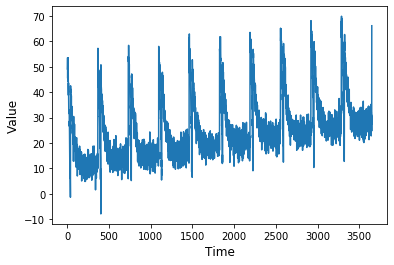

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


In [7]:

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
  tf.keras.layers.Dense(16), 
  tf.keras.layers.Dense(1), 
  tf.keras.layers.Lambda(lambda x: x*100)
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 76,065
Trainable params: 76,065
Non-trainable params: 0
____________________________________________________

In [8]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.RMSprop(lr=1e-8, rho=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
94/94 [==============================] - 7s 78ms/step - loss: 60.9336 - mae: 61.4739
Epoch 2/150
94/94 [==============================] - 4s 38ms/step - loss: 60.8692 - mae: 61.4090
Epoch 3/150
94/94 [==============================] - 4s 37ms/step - loss: 60.7949 - mae: 61.3348
Epoch 4/150
94/94 [==============================] - 3s 37ms/step - loss: 60.7131 - mae: 61.2531
Epoch 5/150
94/94 [==============================] - 4s 37ms/step - loss: 60.6250 - mae: 61.1649
Epoch 6/150
94/94 [==============================] - 4s 38ms/step - loss: 60.5298 - mae: 61.0698
Epoch 7/150
94/94 [==============================] - 4s 37ms/step - loss: 60.4223 - mae: 60.9624
Epoch 8/150
94/94 [==============================] - 4s 38ms/step - loss: 60.2979 - mae: 60.8380
Epoch 9/150
94/94 [==============================] - 4s 37ms/step - loss: 60.1565 - mae: 60.6967
Epoch 10/150
94/94 [==============================] - 4s 38ms/step - loss: 59.9969 - mae: 60.5372
Epoch 11/150
94/94 [=========

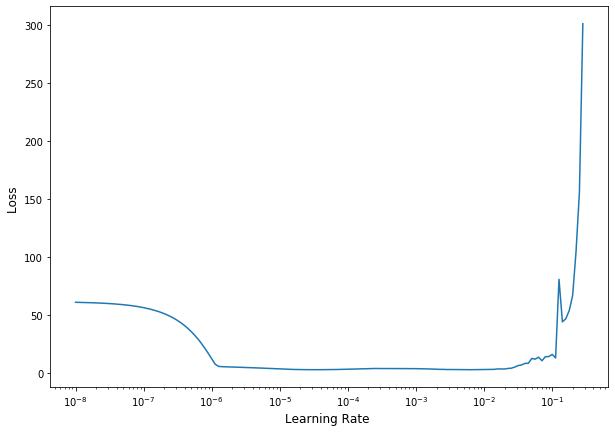

In [9]:
fig = plt.figure(figsize=(10, 7))
plt.xlabel("Learning Rate ", fontsize=12)
plt.ylabel("Loss ", fontsize=12)
plt.xscale('log')
plt.yscale('linear')
plt.plot(history.history["lr"], history.history["loss"])
plt.show()

# FROM THIS PICK A LEARNING RATE

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(16), 
  tf.keras.layers.Dense(1), 
  # YOUR CODE HERE
  tf.keras.layers.Lambda(lambda x: x*100.)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(lr=2e-5, rho=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
94/94 [==============================] - 7s 75ms/step - loss: 116.8411 - mae: 6.9171
Epoch 2/500
94/94 [==============================] - 3s 37ms/step - loss: 53.3669 - mae: 4.5181
Epoch 3/500
94/94 [==============================] - 3s 37ms/step - loss: 43.1752 - mae: 4.0810
Epoch 4/500
94/94 [==============================] - 4s 38ms/step - loss: 38.7157 - mae: 3.8696
Epoch 5/500
94/94 [==============================] - 4s 38ms/step - loss: 36.0970 - mae: 3.7443
Epoch 6/500
94/94 [==============================] - 4s 38ms/step - loss: 34.3343 - mae: 3.6598
Epoch 7/500
94/94 [==============================] - 4s 37ms/step - loss: 33.1006 - mae: 3.5981
Epoch 8/500
94/94 [==============================] - 3s 37ms/step - loss: 32.2150 - mae: 3.5542
Epoch 9/500
94/94 [==============================] - 4s 37ms/step - loss: 31.5569 - mae: 3.5233
Epoch 10/500
94/94 [=====================

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

NameError: ignored

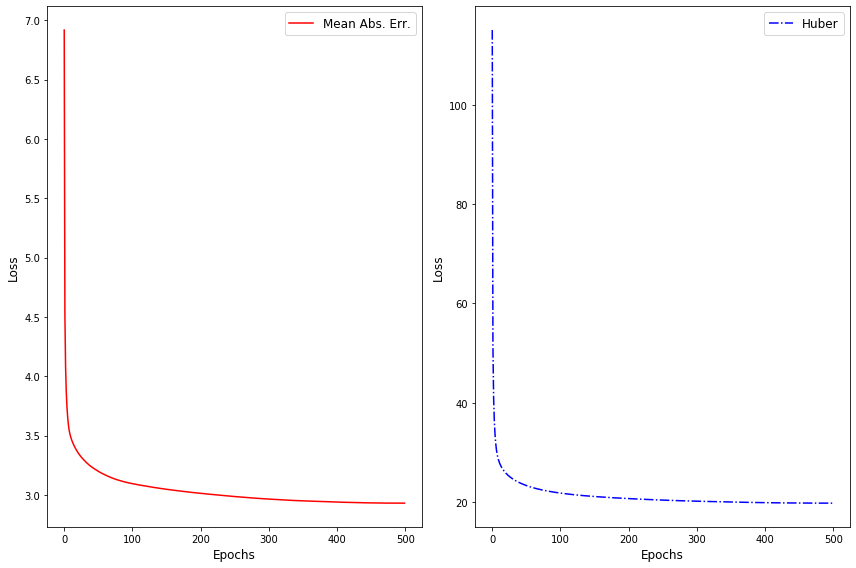

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'r-', label='Mean Abs. Err.')
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-.', label='Huber')
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


<Figure size 432x288 with 0 Axes>

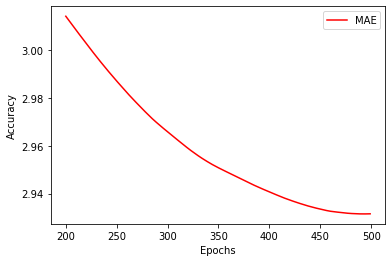

<Figure size 432x288 with 0 Axes>

In [10]:
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
# plt.plot(epochs_zoom, loss_zoom, 'b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE"])

plt.figure()